In [7]:
import glob
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit import DataStructs
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem.Draw import IPythonConsole # Enables RDKit IPython integration
from rdkit.Chem import PandasTools
import seaborn as sns

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [8]:
path_to_library = '/home/paula/Masterarbeit/FragmentLibrary/'

# list of folders for each subpocket
subpockets = ['AP', 'FP', 'SE', 'GA', 'B1', 'B2']
folders = [path_to_library+subpocket for subpocket in subpockets]

In [9]:
# read data

data = pd.DataFrame()

rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)

# iterate over subpockets
for i, folder in enumerate(folders):
    
    subpocket = subpockets[i]
    
    file = folder+'/'+subpocket+'.sdf' 
    df = pd.DataFrame()
    suppl = Chem.SDMolSupplier(file, removeHs=False)
        
    fragments = []
    fingerprints = []
    smiles = []
    groups = []

    for frag in suppl:
        # remove dummy atoms from fragments and create smiles
        du = Chem.MolFromSmiles('*')
        h = Chem.MolFromSmiles('[H]', sanitize=False)
        fixed_frag = AllChem.ReplaceSubstructs(frag, du, h, replaceAll=True)[0]
        fixed_frag = Chem.RemoveHs(fixed_frag)
        s = Chem.MolToSmiles(fixed_frag)
        # remove duplicates based on smiles
        if s in smiles:
            continue
        fragments.append(fixed_frag)
        # fingerprint of fragment
        fingerprints.append(rdkit_gen.GetFingerprint(fixed_frag))
        # smiles for comparing fragments
        smiles.append(s)
        # kinase groups
        groups.append(frag.GetProp('group'))
      
    df['smiles'] = smiles
    df['fragment'] = fragments
    df['fingerprint'] = fingerprints
    df['subpocket'] = subpocket
    df['group'] = groups
    
    data = data.append(df)
    
data = data.reset_index(drop=True)
data.shape

(2977, 5)

In [10]:
n_frags_per_sp = {}
for sp in subpockets:
    n_frags_per_sp[sp] = data[data.subpocket == sp].shape[0]
n_frags_per_sp

{'AP': 1115, 'FP': 864, 'SE': 607, 'GA': 306, 'B1': 42, 'B2': 43}

Similarity of fragments between the kinase groups:

In [11]:
groups = data.group.unique()
groups

array(['Other', 'TK', 'TKL', 'AGC', 'CMGC', 'CAMK', 'CK1', 'STE'],
      dtype=object)

In [12]:
# matrix with mean similarites between groups 
sim_matrix1 = pd.DataFrame(0, index=groups, columns=groups)
# matrix with mean similarities between groups averaged over subpockets
sim_matrix = pd.DataFrame(0, index=groups, columns=groups)
# one similarity matrix for each subpocket
sim_matrices = {}
for sp in subpockets:
    sim_matrices[sp] = pd.DataFrame(0, index=groups, columns=groups)

# iterate over groups
for g1 in groups:
    for g2 in groups:
        
        dg1 = data[data.group==g1]
        dg2 = data[data.group==g2]
        
        sum_all_sims = 0
        count_all_sims = 0
        sum_mean_sims = 0
        count_sps = 0
        # iterate over subpockets
        for sp in subpockets:
            
            dg1sp = dg1[dg1.subpocket==sp]
            dg2sp = dg2[dg2.subpocket==sp]
            
            if dg1sp.empty or dg2sp.empty:
                sim_matrices[sp].loc[g1,g2] = None
                continue
            
            count_sims = 0
            sum_sims = 0
            # iterate over fragment pairs
            for i, fp1 in enumerate(dg1sp.fingerprint):
                for j, fp2 in enumerate(dg2sp.fingerprint):
                    
                    if g1 != g2 or i != j:
                        sim = DataStructs.FingerprintSimilarity(fp1, fp2) # tanimoto similarity
                        sum_sims += sim
                        sum_all_sims += sim
                        count_sims += 1
                        count_all_sims += 1
            
            # if nothing was compared
            if count_sims == 0:
                sim_matrices[sp].loc[g1,g2] = None
                continue
                        
            mean_sim = sum_sims/count_sims  
            sum_mean_sims += mean_sim
            count_sps += 1
            sim_matrices[sp].loc[g1,g2] = mean_sim
   
        sim_matrix1.loc[g1,g2] = sum_all_sims/count_all_sims
        
        sim_matrix.loc[g1, g2] = sum_mean_sims/count_sps

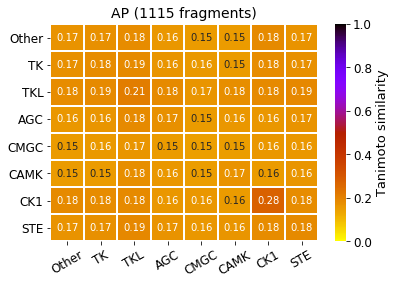

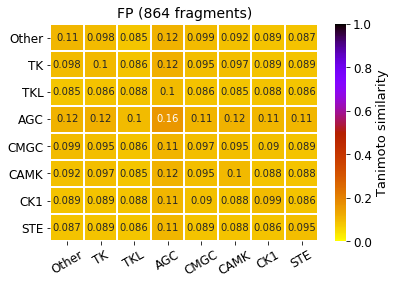

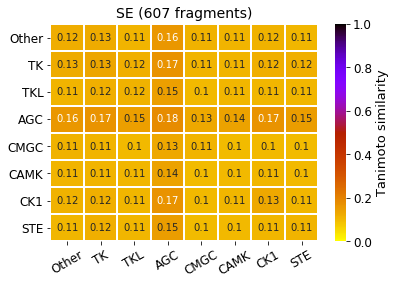

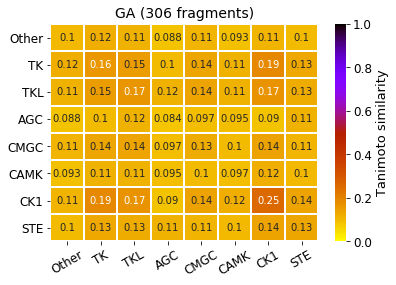

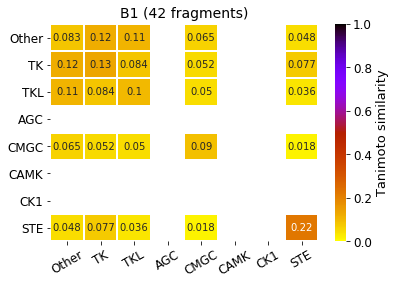

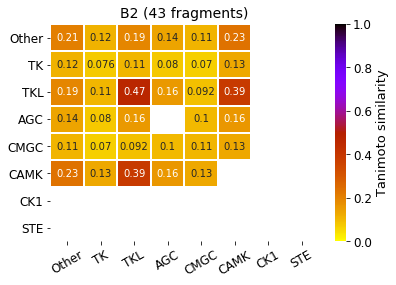

In [13]:
for sp in subpockets:
    ax = sns.heatmap(sim_matrices[sp], linewidths=1, annot=True, annot_kws={"size": 10}, cbar_kws={"label": "Tanimoto similarity"}, cmap="gnuplot_r",
               vmin=0, vmax=1)
    plt.title(sp+' ('+str(n_frags_per_sp[sp])+' fragments)', fontsize=14)
    plt.xticks(fontsize=12, rotation=30)
    plt.yticks(fontsize=12)
    ax.figure.axes[-1].yaxis.label.set_size(13)
    cax = plt.gcf().axes[-1]
    cax.tick_params(labelsize=12)
    plt.show()

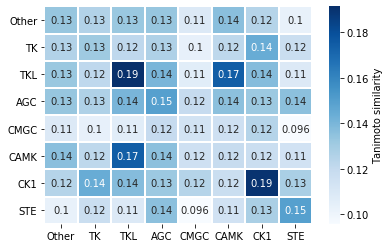

In [14]:
sns.heatmap(sim_matrix, linewidths=1, annot=True, cbar_kws={"label": "Tanimoto similarity"}, cmap="Blues")
plt.show()

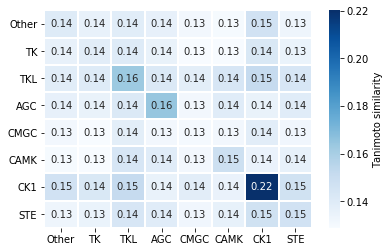

In [15]:
sns.heatmap(sim_matrix1, linewidths=1, annot=True, cbar_kws={"label": "Tanimoto similarity"}, cmap="Blues")
plt.show()

Similarity of fragments within kinase groups per subpocket:

In [16]:
sim_matrix = pd.DataFrame(0, index=groups, columns=['AP', 'FP', 'SE', 'GA', 'B1', 'B2'])
sims1 = pd.Series(0, index=groups)

sim_data = {}

# iterate over kinase groups
for group in groups:
    
    dg = data[data.group==group]
    
    sum_all_sims = 0
    count_all_sims = 0
    sim_data_group = []
    
    # iterate over subpockets
    for sp in subpockets:
        
        dgsp = dg[dg.subpocket==sp]
        
        sum_sims = 0
        count_sims = 0
        # iterate over fragment pairs
        for i, fp1 in enumerate(dgsp.fingerprint):
            for j, fp2 in enumerate(dgsp.fingerprint):
                
                if i != j:

                    sim = DataStructs.FingerprintSimilarity(fp1, fp2) # tanimoto similarity
                    sum_sims += sim
                    sum_all_sims += sim
                    count_sims += 1
                    count_all_sims += 1
                    sim_data_group.append(sim)
                    
        if count_sims == 0:
            sim_matrix.loc[group, sp] = None
            continue
                    
        mean_sim = sum_sims/count_sims
        sim_matrix.loc[group, sp] = mean_sim
        
    mean_group = sum_all_sims/count_all_sims
    sims1.loc[group] = mean_group
    
    sim_data[group] = sim_data_group

In [17]:
sim_df = pd.DataFrame(columns=['Tanimoto similarity'])
for group in groups:
    df = pd.DataFrame(sim_data[group], columns=['Tanimoto similarity'])
    df['group'] = group
    sim_df = sim_df.append(df)

/home/paula/anaconda3/envs/kffl/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [18]:
# plt.figure(figsize=(10,8))
# ax = sns.violinplot(x='group', y='Tanimoto similarity', data=sim_df, color='dodgerblue')
# plt.xticks(fontsize=17)
# plt.yticks(fontsize=17)
# plt.ylabel('Tanimoto similarity', fontsize=17)
# plt.xlabel('Kinase group', fontsize=17)

Similarity within subpockets:

In [19]:
sims = pd.Series(0, index=subpockets)
sim_data = {}
count_equal = {}

# total similarity per subpocket
for sp in subpockets:
    
        dsp = data[data.subpocket==sp]
        sim_data_sp = []
        count_equal[sp] = 0
        
        sum_sims = 0
        count_sims = 0
        # iterate over fragment pairs
        for i, fp1 in enumerate(dsp.fingerprint):
            for j, fp2 in enumerate(dsp.fingerprint):
                
                if i != j:

                    sim = DataStructs.FingerprintSimilarity(fp1, fp2)
                    if sim == 1:
                        count_equal[sp] += 1
                    sim_data_sp.append(sim)
                    sum_sims += sim # tanimoto similarity
                    count_sims += 1
                    
        if count_sims == 0:
            sims.loc[sp] = None
            continue
                    
        mean_sim = sum_sims/count_sims
        sims.loc[sp] = mean_sim
        
        sim_data[sp] = sim_data_sp

In [20]:
def flatten_dict(d):
    
    lst = []
    for key in d:
        lst.extend(d[key])
    return lst

In [21]:
# Total distribution of similarities within subpockets
df = pd.DataFrame(data=flatten_dict(sim_data), columns=['Tanimoto similarity'])
df['group'] = 'Total'

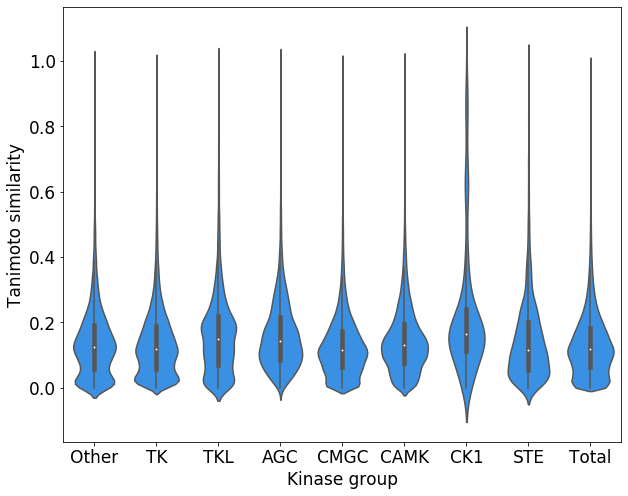

In [22]:
# same plot with Total distribution
sim_df = sim_df.append(df)

plt.figure(figsize=(10,8))
ax = sns.violinplot(x='group', y='Tanimoto similarity', data=sim_df, color='dodgerblue')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.ylabel('Tanimoto similarity', fontsize=17)
plt.xlabel('Kinase group', fontsize=17)
plt.savefig('/home/paula/Masterarbeit/manuscript/Figures/fa_sim_intragroup.png', dpi=300)

In [23]:
count_equal

{'AP': 70, 'FP': 94, 'SE': 42, 'GA': 8, 'B1': 0, 'B2': 0}

In [24]:
count_equal['AP']/len(sim_data['AP'])

5.635571728751882e-05

In [25]:
colors=['purple','forestgreen','c','tab:orange','tab:blue','darkslateblue']

In [26]:
subpockets = ['AP', 'FP', 'SE', 'GA', 'B1', 'B2']

In [27]:
sim_df = pd.DataFrame(columns=['Tanimoto similarity'])
for sp in subpockets:
    df = pd.DataFrame(sim_data[sp], columns=['Tanimoto similarity'])
    df['subpocket'] = sp
    sim_df = sim_df.append(df)

In [28]:
my_pal = {"AP": "purple", "FP": "forestgreen", "SE":"c", "GA":"tab:orange", "B1":"tab:blue", "B2":"darkslateblue"}

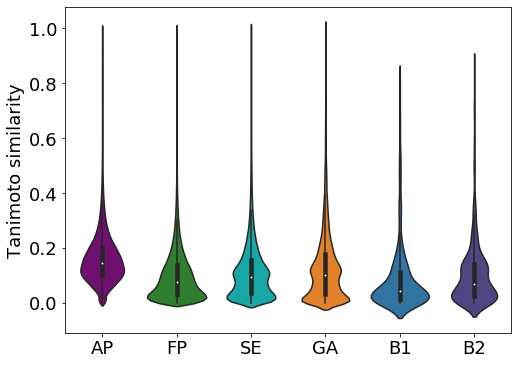

In [34]:
plt.figure(figsize=(8,6))
ax = sns.violinplot(x='subpocket', y='Tanimoto similarity', data=sim_df, palette=my_pal)
plt.ylabel('Tanimoto similarity', fontsize=18)
plt.xlabel('', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig('/home/paula/Masterarbeit/manuscript/Figures/fa_sim_subpockets.pdf', dpi=300)

In [30]:
sims

AP    0.161217
FP    0.099333
SE    0.116093
GA    0.127126
B1    0.086658
B2    0.102145
dtype: float64

In [31]:
sims1

Other    0.140347
TK       0.138856
TKL      0.163375
AGC      0.164700
CMGC     0.130388
CAMK     0.148286
CK1      0.220189
STE      0.146442
dtype: float64

In [32]:
sim_matrix.loc['Total'] = sims
sim_matrix['Total'] = sims1

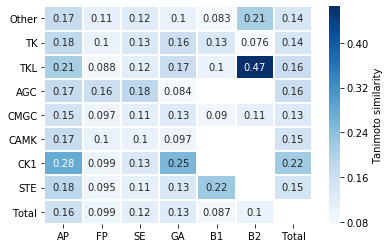

In [33]:
sns.heatmap(sim_matrix, linewidths=1, annot=True, cbar_kws={"label": "Tanimoto similarity"}, cmap="Blues")
plt.show()